In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf, validate_on, file_mfccs, segments_from_audio_file
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.001

In [2]:
trained_model_mfcc_seq = tf.keras.models.load_model("models/mfcc_seq.h5")
trained_model_mfcc_conv = tf.keras.models.load_model("models/mfcc_conv_mini.h5")
train_ds, val_ds, label_names = dataset_tf("dataset/osbh_sep_1", 0.8, 8)
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)

2024-03-30 18:13:05.517622: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-30 18:13:05.517650: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-30 18:13:05.517658: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-30 18:13:05.517690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-30 18:13:05.517705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 130 files belonging to 2 classes.
Using 78 files for training.
Using 52 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (8, 4000)
Example label shape: (8,)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
513 44100


# Train

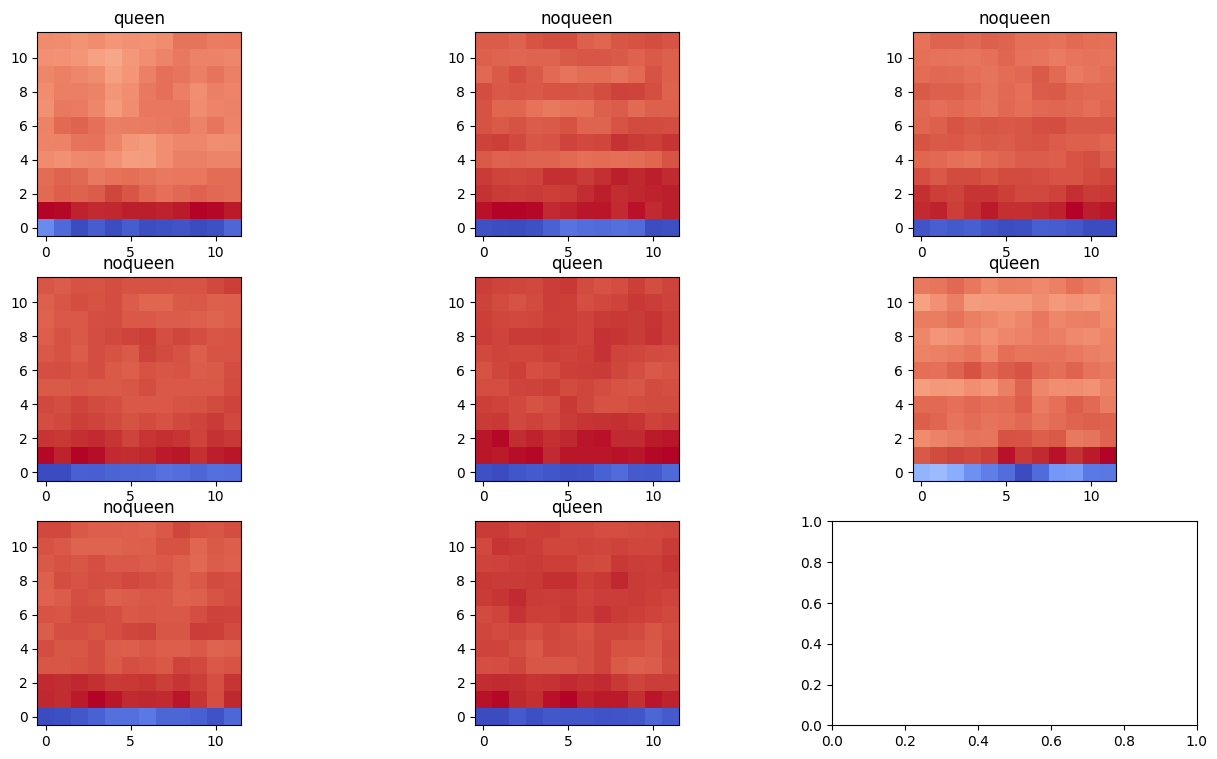

In [3]:
for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break

plot_mfccs(example_mfccs, example_mfccs_labels, label_names)

In [4]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))

for example_mfccs, example_mfccs_labels in train_mfccs_ds.take(1):
  break
input_shape = example_mfccs.shape[1:]
print(input_shape)
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

(12, 12, 1)


# EVAL

In [5]:
results = trained_model_mfcc_seq.evaluate(val_mfccs_ds)
print(f"MFCC Seq: {results}")
results = trained_model_mfcc_conv.evaluate(val_mfccs_ds)
print(f"MFCC Conv: {results}")

7/7 [==============================] - 0s 15ms/step - loss: 2.6604 - accuracy: 0.3077


2024-03-30 18:13:07.304821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


MFCC Seq: [2.6603622436523438, 0.3076923191547394]
7/7 [==============================] - 1s 73ms/step - loss: 1.7678 - accuracy: 0.3269
MFCC Conv: [1.7677892446517944, 0.32692307233810425]


## Sequential

Epoch 1/10


2024-03-30 18:13:08.236965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


10/10 [==============================] - 1s 97ms/step - loss: 1.8600 - accuracy: 0.4615 - val_loss: 1.2844 - val_accuracy: 0.6538
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 1.2475 - accuracy: 0.5513 - val_loss: 0.7200 - val_accuracy: 0.6154
Epoch 3/10
10/10 [==============================] - 0s 16ms/step - loss: 0.9762 - accuracy: 0.6282 - val_loss: 0.6261 - val_accuracy: 0.7115
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.6627 - accuracy: 0.6538 - val_loss: 0.6980 - val_accuracy: 0.6731
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.6218 - accuracy: 0.7051 - val_loss: 0.6805 - val_accuracy: 0.6731
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.5332 - accuracy: 0.7564 - val_loss: 0.5464 - val_accuracy: 0.7308
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.4116 - accuracy: 0.8718 - val_loss: 0.6319 - val_accuracy: 0.6923
Epoch 8/10
10/10 [======

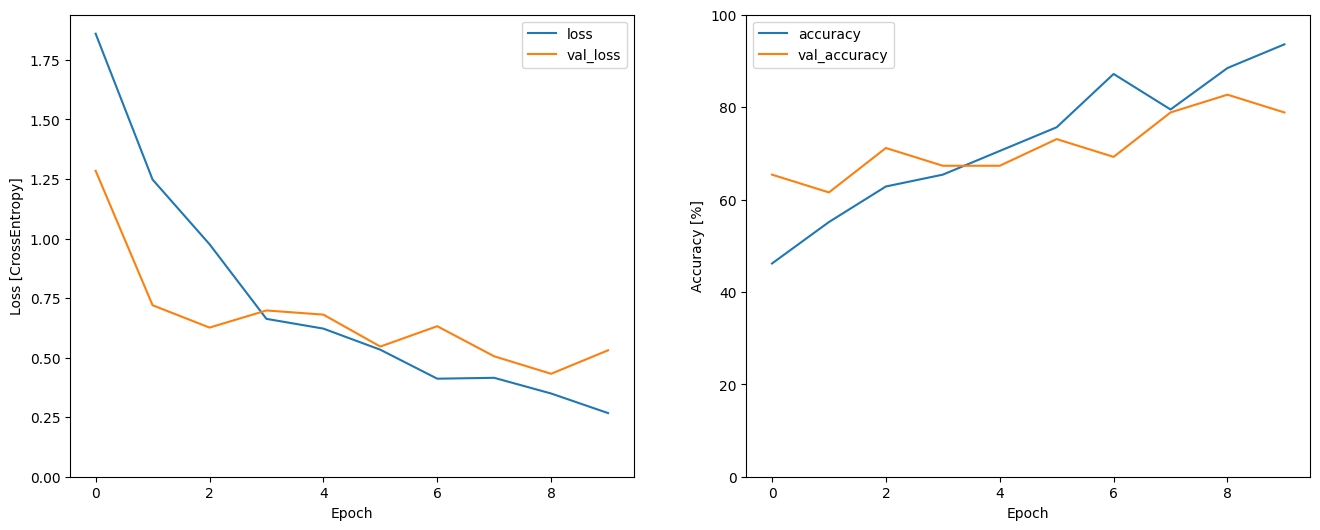

In [6]:
trained_history_mfcc_seq = trained_model_mfcc_seq.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_seq)

## Convolutional

Epoch 1/10
10/10 [==============================] - 1s 48ms/step - loss: 1.1041 - accuracy: 0.4744 - val_loss: 0.7890 - val_accuracy: 0.6538
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.8074 - accuracy: 0.6026 - val_loss: 0.7165 - val_accuracy: 0.5385
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.7363 - accuracy: 0.5513 - val_loss: 0.5784 - val_accuracy: 0.7115
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.5859 - accuracy: 0.7179 - val_loss: 0.5008 - val_accuracy: 0.8077
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.5106 - accuracy: 0.7564 - val_loss: 0.4798 - val_accuracy: 0.7885
Epoch 6/10
10/10 [==============================] - 0s 8ms/step - loss: 0.4649 - accuracy: 0.7949 - val_loss: 0.4745 - val_accuracy: 0.7885
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 0.4347 - accuracy: 0.7821 - val_loss: 0.4213 - val_accuracy: 0.8077
Epoch 8/10
10/10 [=

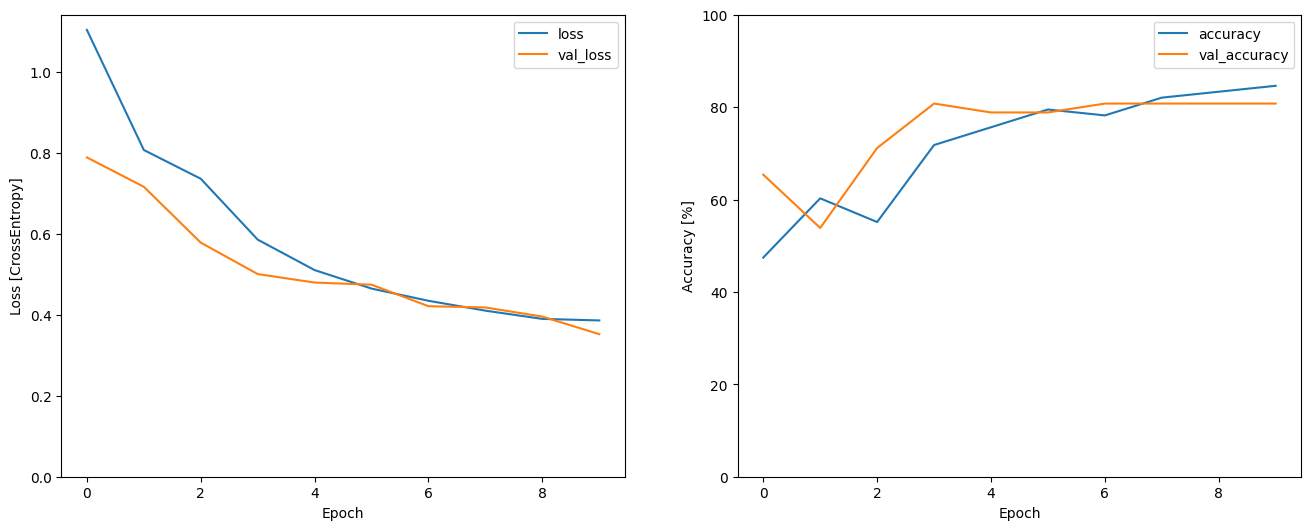

In [7]:
trained_history_mfcc_conv = trained_model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=10,
    # callbacks=callbacks
)
plot_history(trained_history_mfcc_conv)

# Summary

In [8]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f},   VL: {history.history['val_loss'][-1]:.2f}, VA: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("Trained MFCCs + Seq ", trained_history_mfcc_seq)
history_to_summary("Trained MFCCs + Conv", trained_history_mfcc_conv)

Trained MFCCs + Seq :    Loss: 0.27, Acc: 0.94,   VL: 0.53, VA: 0.79
Trained MFCCs + Conv:    Loss: 0.39, Acc: 0.85,   VL: 0.35, VA: 0.81
